<a href="https://colab.research.google.com/github/nedelculiviu95/cnn-detecting-lung-opacities/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install pydicom
import glob, pylab, pandas as pd
import pydicom, numpy as np

df = pd.read_csv('/content/gdrive/My Drive/train_images/stage_1_train_labels.csv')
print(df.iloc[4])

patientId = df['patientId'][0]
dcm_file = '/content/gdrive/My Drive/train_images/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


OSError: ignored

[[144 128 114 ... 176 184 117]
 [125 109  95 ... 171 178 111]
 [104  89  75 ... 166 175 108]
 ...
 [ 16  14  11 ...  19  15   3]
 [ 18  16  12 ...  21  17   5]
 [ 19  17  13 ...  23  19   6]]
<class 'numpy.ndarray'>
uint8
(1024, 1024)
{'dicom': '/content/gdrive/My Drive/train_images/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


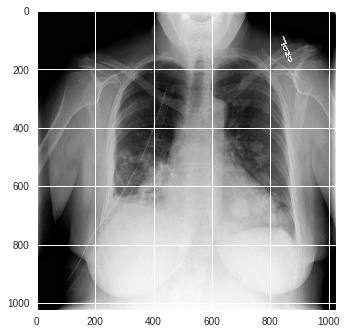

In [0]:
im = dcm_data.pixel_array #accesing Pixel Data
print(im)
print(type(im))
print(im.dtype)
print(im.shape) #1024x1024 image


def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/content/gdrive/My Drive/train_images/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(df)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

pylab.imshow(im, cmap=pylab.cm.gist_gray)

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object
{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 8964}


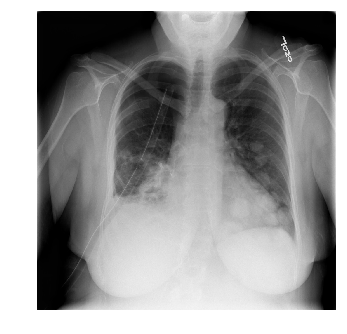

In [0]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')
def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

df_detailed = pd.read_csv('/content/gdrive/My Drive/train_images/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [0]:
image_size = 224
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f5f70531b38> False
<keras.layers.convolutional.Conv2D object at 0x7f5f70531d68> False
<keras.layers.convolutional.Conv2D object at 0x7f5f70531ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f70538908> False
<keras.layers.convolutional.Conv2D object at 0x7f5f70538cc0> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fcfb438> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f6fc95080> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fc95ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fcc8048> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fc63320> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f6fc7a278> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fc7aeb8> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fc2b048> False
<keras.layers.convolutional.Conv2D object at 0x7f5f6fc46320> F

In [0]:
image_size = 224

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

NameError: ignored

In [0]:
model = keras.applications.densenet.DenseNet121()
model.summary()

NameError: ignored